# Time series by admin3

In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt

from ochanticipy import create_country_config, CodAB

import utils


pio.renderers.default = "notebook"

/Users/tdowning/.pyenv/versions/pa-aa-ner-flooding/lib/python3.11/site-packages/quantulum3/classifier.py:28: UserWarning: Classifier dependencies not installed. Run pip install quantulum3[classifier] to install them. The classifer helps to dissambiguate units.
  warnings.warn(


In [3]:
PROC_DIR = utils.DATA_DIR / "public/processed/ner/anadia"
GAYA = "NER003006003"
TANDA = "NER003006004"
TOUNOUGA = "NER003006005"
SAMBERA = "NER003004008"
GREEN = "#1bb580"
# remove Sambera due to relatively low flood extent
ADM3S = [GAYA, TANDA, TOUNOUGA]

In [4]:
adm1s = ["Dosso", "Tillabéri"]
country_config = create_country_config("ner")
codab = CodAB(country_config=country_config)
codab = codab.load(admin_level=3)
codab = codab[codab["adm_01"].isin(adm1s)]
codab = codab.set_crs(4326)

In [5]:
impact = utils.load_processed_anadia()
floodscan = utils.load_processed_floodscan()
niamey = utils.load_abn_niamey()
abn = utils.load_combined_abn()
abn = utils.shift_to_floodseason(abn)

In [6]:
niamey = utils.shift_to_floodseason(niamey, use_index=True)
niamey_peaks = utils.get_peak(niamey, max_col="Water Level (cm)")
fs_peaks = utils.get_peak(floodscan, max_col="mean_cell")
fs_total = (
    floodscan.groupby(["seasonyear", utils.ID_COL])["mean_cell"]
    .sum()
    .reset_index()
)
fs_total = fs_total.rename(columns={"mean_cell": "mean_cell_total"})
niamey_triggers = utils.get_triggers(niamey, threshold=580, date_col="Date")

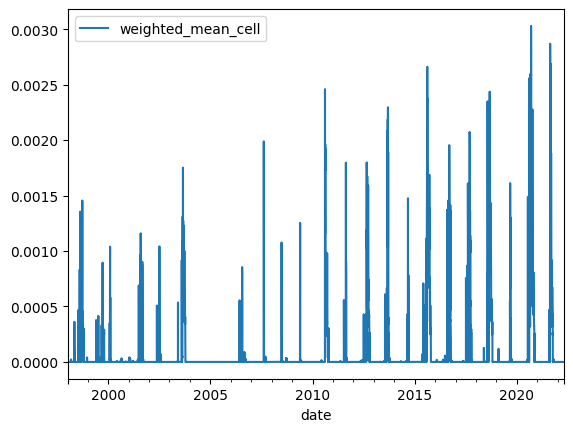

In [7]:
# average floodscan over adm3s (weighted by area)
fs_average = floodscan[floodscan[utils.ID_COL].isin(ADM3S)].merge(
    codab[[utils.ID_COL, "Shape_Area"]], on=utils.ID_COL
)
fs_average["weighted_mean_cell"] = (
    fs_average["mean_cell"] * fs_average["Shape_Area"]
)
fs_average = fs_average.groupby("date").mean(numeric_only=True).reset_index()
fs_average.plot(x="date", y="weighted_mean_cell")
fs_average[utils.ID_COL] = "selected_adm3s"

In [8]:
fs_niamey = fs_peaks.merge(niamey_triggers, on="seasonyear", how="left")
fs_niamey = fs_niamey.merge(
    niamey_peaks[["Water Level (cm)", "seasonyear"]], on="seasonyear"
)
fs_niamey = fs_niamey.merge(fs_total, on=[utils.ID_COL, "seasonyear"])
fs_niamey = fs_niamey[fs_niamey[utils.ID_COL].isin(ADM3S)]
fs_niamey["leadtime"] = (fs_niamey["date"] - fs_niamey["t_date"]).dt.days
fs_niamey = fs_niamey.merge(codab[[utils.ID_COL, "adm_03"]], on=utils.ID_COL)

0         Annotation(3.44081, 11.903, 'Gaya')
1    Annotation(3.60296, 11.8064, 'Tounouga')
2       Annotation(3.32482, 12.0589, 'Tanda')
dtype: object

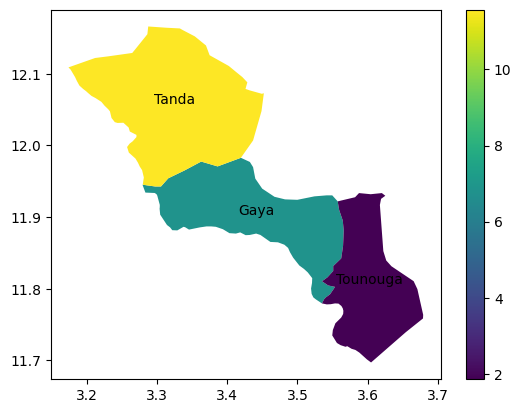

In [9]:
fig, ax = plt.subplots()
df_plot = codab.merge(
    fs_niamey.groupby(utils.ID_COL).mean(numeric_only=True), on=utils.ID_COL
)

df_plot.plot(column="leadtime", legend=True, ax=ax)
df_plot.apply(
    lambda x: ax.annotate(
        text=x["adm_03"], xy=x.geometry.centroid.coords[0], ha="center"
    ),
    axis=1,
)

In [16]:
# plot leadtimes by adm3

station = "Garbe Kourou"
station = "Niamey"
niamey_t = 580
gk_t = 450

abn_f = abn[abn["station"] == station]
display(abn_f)
triggers = utils.get_triggers(abn_f, threshold=niamey_t, date_col="date")

impact_g = (
    impact[impact[utils.ID_COL] == GAYA]
    .groupby(impact.date.dt.year)
    .sum(numeric_only=True)
)
floodscan_g = floodscan[floodscan[utils.ID_COL] == GAYA]
floodscan_g = fs_average.copy()
floodscan_g["mean_rolling"] = (
    floodscan_g["weighted_mean_cell"].rolling(10, center=True).mean()
)

compare = floodscan_g.merge(
    abn_f[["date", "Water Level (cm)"]], on="date", how="left"
)

leadtimes = []

max_fs = 0.002
max_niamey = 800
years = triggers["seasonyear"].unique()
for year in years:
    dff = compare[compare["seasonyear"] == year]
    dff_t = triggers[triggers["seasonyear"] == year]

    fig = make_subplots(specs=[[{"secondary_y": True}]])
    fig.add_trace(
        go.Scatter(
            x=dff["date"],
            y=dff["Water Level (cm)"],
            line_color="dodgerblue",
            name=f"Niveau d'eau<br>à {station} (cm)",
        ),
        secondary_y=False,
    )
    fig.add_trace(
        go.Scatter(
            x=dff["date"],
            y=dff["mean_rolling"],
            line_color="crimson",
            name="Étendue<br>d'inondation",
        ),
        secondary_y=True,
    )

    if not dff_t.empty:
        t_date = dff_t.iloc[0]["t_date"]
        fig.add_trace(
            go.Scatter(
                x=[t_date, t_date],
                y=[0, max_niamey],
                mode="lines+text",
                line=dict(color="dodgerblue", width=2, dash="dot"),
                text=["", f"Déclenchement:  <br>{t_date:%b %d}  "],
                textposition="bottom left",
                textfont_color="dodgerblue",
                showlegend=False,
            ),
            secondary_y=False,
        )

    fs_peak_row = dff.loc[dff["mean_rolling"].idxmax()]
    peak_date = fs_peak_row["date"]
    peak_level = fs_peak_row["mean_rolling"]
    leadtime = peak_date - t_date
    leadtimes.append(leadtime.days)

    fig.add_trace(
        go.Scatter(
            x=[peak_date, peak_date],
            y=[0, max_fs],
            text=[
                "",
                f"  Étendue max.:<br>  {peak_date:%b %d}<br>  (préavis {leadtime.days} jours)",
            ],
            textfont_color="crimson",
            line=dict(color="crimson", width=2, dash="dot"),
            mode="lines+text",
            textposition="bottom right",
            showlegend=False,
        ),
        secondary_y=True,
    )

    fig.update_layout(
        template="simple_white",
        title=f"Inondations à Gaya, Tounouga, et Tanda en {year}",
        width=700,
    )
    fig.update_yaxes(
        range=[0, max_niamey],
        secondary_y=False,
        color="dodgerblue",
        title="Niveau d'eau (cm)",
    )
    fig.update_yaxes(
        range=[0, max_fs],
        secondary_y=True,
        color="crimson",
        title="Étendue d'inondation",
    )
    fig.update_legends(y=1, x=0.93, xanchor="right")
    min_date = dff["date"].min()
    max_date = dff["date"].max() - pd.Timedelta(days=100)
    fig.update_xaxes(range=[min_date, max_date])

    fig.show()

print(np.mean(leadtimes))

,date,Water Level (cm),Discharges (m3/s),station,dayofseason,seasonyear
0,2005-01-01,459.667,1367.244,Niamey,213,2004
1,2005-01-02,457.667,1354.711,Niamey,214,2004
2,2005-01-03,455.667,1342.178,Niamey,215,2004
3,2005-01-04,453.667,1329.644,Niamey,216,2004
4,2005-01-05,451.000,1312.933,Niamey,217,2004
...,...,...,...,...,...,...
6417,2022-07-28,298.000,355.000,Niamey,56,2022
6418,2022-07-29,298.000,355.000,Niamey,57,2022
6419,2022-07-30,336.000,485.500,Niamey,58,2022
6420,2022-07-31,361.500,585.500,Niamey,59,2022


7.285714285714286


<Axes: >

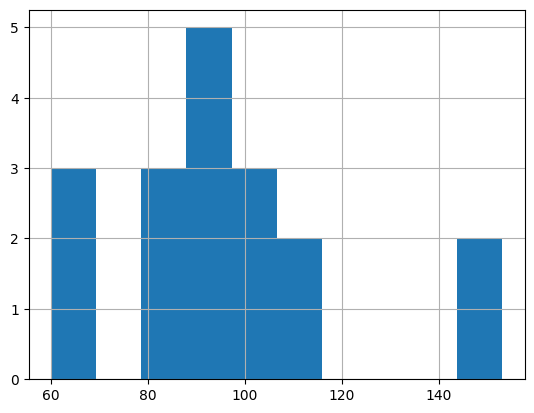

In [23]:
niamey_peaks["dayofseason"].hist()

In [170]:
# correlation between peaks
df_plot = floodscan[floodscan[utils.ID_COL] == TOUNOUGA]
px.line(df_plot, x="dayofseason", y="mean_cell", color="seasonyear")

In [411]:
# FS - ABN correlation

station = "Garbe Kourou"
# station = "Niamey"
abn_f = abn[abn["station"] == station]
abn_f = abn_f[abn_f["dayofseason"] < utils.FLOODSEASON_ENDDAY]
abn_f = abn_f.groupby("seasonyear").max(numeric_only=True)
abn_f = abn_f.merge(
    fs_niamey[[utils.ID_COL, "seasonyear", "mean_cell_total", "adm_03"]],
    on="seasonyear",
)

avg_corr = []

for adm3 in abn_f[utils.ID_COL].unique():
    dff = abn_f[abn_f[utils.ID_COL] == adm3]
    name = dff.iloc[0]["adm_03"]
    corr = dff.corr(numeric_only=True)
    display(corr)
    avg_corr.append(corr.loc["Water Level (cm)", "mean_cell_total"])
    fig = px.scatter(
        dff, x="Water Level (cm)", y="mean_cell_total", trendline="ols"
    )
    fig.update_traces(marker_color=GREEN, marker_size=10)
    fig.update_layout(
        template="simple_white",
        title=name,
        height=500,
        width=500,
    )
    fig.update_yaxes(title="Étendue d'inondation", rangemode="tozero")
    fig.update_xaxes(title=f"Niveau d'eau maximum à {station} (cm)")
    fig.show()

print(np.mean(avg_corr))

,seasonyear,Water Level (cm),Discharges (m3/s),dayofseason,mean_cell_total
seasonyear,1.000000,-0.115958,-0.058235,-0.807601,0.188234
Water Level (cm),-0.115958,1.000000,0.996897,-0.126905,0.395637
Discharges (m3/s),-0.058235,0.996897,1.000000,-0.174629,0.370866
dayofseason,-0.807601,-0.126905,-0.174629,1.000000,-0.065556
mean_cell_total,0.188234,0.395637,0.370866,-0.065556,1.000000


,seasonyear,Water Level (cm),Discharges (m3/s),dayofseason,mean_cell_total
seasonyear,1.000000,-0.115958,-0.058235,-0.807601,0.048642
Water Level (cm),-0.115958,1.000000,0.996897,-0.126905,0.869076
Discharges (m3/s),-0.058235,0.996897,1.000000,-0.174629,0.860084
dayofseason,-0.807601,-0.126905,-0.174629,1.000000,-0.321227
mean_cell_total,0.048642,0.869076,0.860084,-0.321227,1.000000


,seasonyear,Water Level (cm),Discharges (m3/s),dayofseason,mean_cell_total
seasonyear,1.000000,-0.115958,-0.058235,-0.807601,-0.268852
Water Level (cm),-0.115958,1.000000,0.996897,-0.126905,0.590876
Discharges (m3/s),-0.058235,0.996897,1.000000,-0.174629,0.549999
dayofseason,-0.807601,-0.126905,-0.174629,1.000000,-0.045360
mean_cell_total,-0.268852,0.590876,0.549999,-0.045360,1.000000


0.6185294061945101
